In [3]:
import numpy as np
from scipy.special import expit
from scipy import optimize

from sklearn.base import BaseEstimator,ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.optimize import _check_optimize_result
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.preprocessing import LabelBinarizer

In [28]:
def _loss_and_grad(w,K,y,alpha, clip = 30):
    """
   Computes the loss and the gradient
    The loss is the negative likelihood function
    :param w:
        array-like oh shape (n_samples,)
        weights
    :param K:
        array-like of shape (n_sample, n_samples)
        the kernel matrix
    :param y:
        array-like of shape (n_samples,)
        labels
    :param alpha:
        float
        penalty parameter
    :return:
        out : float
            The loss
        grad : ndarray of shape (X.shape[0],)
            The gradient
    """
    
    n_samples = K.shape[0]
    linear_prediction = K.dot(w)
    penalty = (alpha/2.) *w.T.dot(K).dot(w)
    
    # loss
    out = np.sum(-y*linear_prediction + np.log(1+np.exp(linear_prediction))) + penalty
    # a.k.a logistic sigmoid
    z = expit(linear_prediction)
    z0 = y -z-alpha*w
    
    grad = -K.dot(z0)
    
    return out,grad

def _kernel_logistic_regression_path(X,y,max_iter,tol = 1e-4, coef = None,
                                    solver = 'lbfgs', check_input = True,
                                    C = 1):
    """
    Compute the kernel logistic regression model
    :param K:
        array-like of shape (n_sample, n_features)
        Input pitchfx
    :param y:
        array-like of shape (n_samples,)
        Input pitchfx, target values
    :param tol:
        float, default = 1e-4
        The stopping criterion for the solver
    :param coef:
        array-like of shape (n_samples,)
        Initialisation values of coefficients for the regression
    :param solver:
        str
        The solver to be used
    :param check_input:
        bool, default = True
        Determines whether the input pitchfx should be checked
    :return:
        w0 : ndarray of shape
    """   
    n_samples, n_features = X.shape
    classes = np.unique(y)
    
    if not classes.size == 2:
        raise ValueError('Only binary Classfication')
        
    func = _loss_and_grad
    
    if coef is None:
        w0 = np.zeros(n_samples,order = 'F',dtype= X.dtype)
    else:
        w0 = coef
        
    if solver == 'lbfgs':
        iprint = [-1,50,1,100,101]
        opt_res = optimize.minimize(
            func,w0,method = 'L-BFGS-B',jac =True,
            args = (X,y,1./C,30),
            options = {'iprint':iprint,'gtol':tol,'maxiter':max_iter}
        )
        
    n_iter = _check_optimize_result(solver,opt_res,max_iter)
    w0, loss = opt_res.x,opt_res.fun
    
    return np.array(w0),n_iter

In [61]:
class KernelLogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self,
                kernel = 'rbf',
                learning_rate = 1,
                gamma = 1,
                degree = 3,
                coef0 = 1,
                C = 1,
                tol = 1e-4,
                kernel_params = None,
                max_iter = 1000):
        self.kernel = kernel
        self.learning_rate  = learning_rate
        self.gamma = gamma
        self.degree = degree
        self.coef0= coef0
        self.C =C
        self.tol = tol
        self.kernel_params = kernel_params
        self.max_iter= max_iter
    
    def _get_kernel(self, X,Y = None):
        if callable(self.kernel):
            params = self.kernel_params or {}
        else :
            params = {'gamma':self.gamma,
                     'degree':self.degree,
                     'coef0':self.coef0}
        return pairwise_kernels(X,Y,metric = self.kernel,
                               filter_params = True, **params) +1
   
    def fit(self,X,y):
        if self.C <0 :
            raise ValueError("Penalty should be positive")
        
        self.X_ = X
        
        X,y = check_X_y(X,y,accept_sparse = True)
        self.label_encoder_ = LabelBinarizer(neg_label = 0, pos_label = 1)
        y_ = self.label_encoder_.fit_transform(y).reshape((-1))
        
        self.classes_ = self.label_encoder_.classes_
        K = self._get_kernel(X)
        
        self.coef_, self.n_iter_ = _kernel_logistic_regression_path(K,y_,tol = self.tol,
                                                                   coef = None, C =self.C,
                                                                   solver = 'lbfgs',check_input = True,
                                                                   max_iter = self.max_iter)
        self.is_fitted_ = True
        
        return self
    
    def decision_function(self,X):
        check_is_fitted(self,['X_','coef_'])
        K = self._get_kernel(X,self.X_)
        scores = K.dot(self.coef_)
        
        return scores
    
    def predict(self,X):
        scores = self.decision_function(X)
        indices = (scores>0).astype(np.int)
        return self.classes_[indices]
    
    def predict_proba(self,X):
        check_is_fitted(self)
        pred_1 = expit(self.decision_function(X).clip(-30,30).reshape((-1,1)))
        return np.hstack((1.0 - pred_1, pred_1))
        
    def predict_log_proba(self,X):
        check_is_fitted(self)
        return np.log(self.predict_proba(X))
    

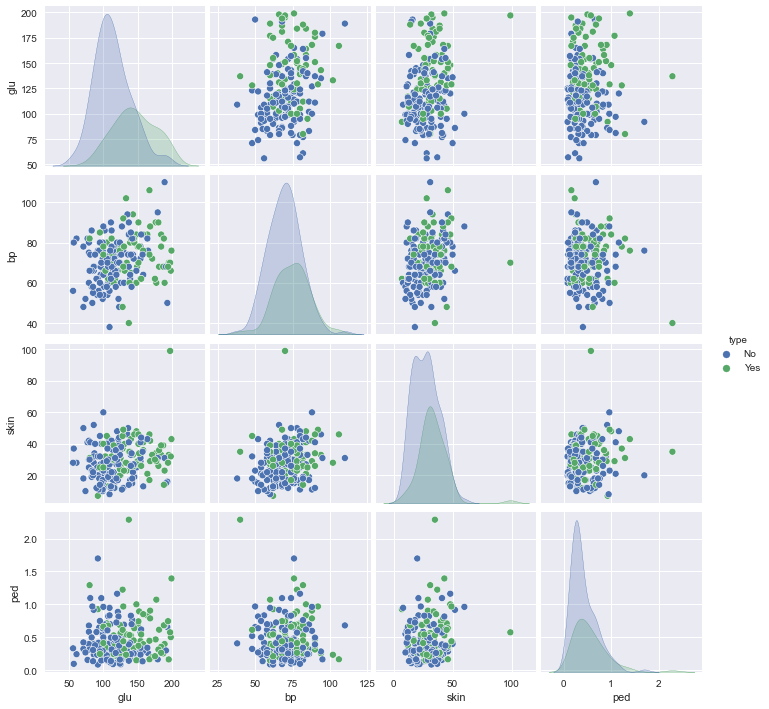

In [44]:
import warnings
warnings.filterwarnings("ignore")
import pydataset
train = pydataset.data("Pima.tr") # 200 subjects
test = pydataset.data("Pima.te") # remaining 332 subjects
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")
sns.pairplot(train.iloc[:, [1, 2, 3, 5, -1]], hue="type")
plt.show()

In [45]:
import numpy as np
import matplotlib as mpl
from matplotlib import colors
cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7)],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
plt.cm.register_cmap(cmap=cmap)
# plot boundary function
def plot_boundary(fit, X, y, ax, res=100, dim=(0, 1)):
    ax.scatter(X[:, dim[0]], X[:, dim[1]], c=y, cmap="red_blue_classes",
              linewidths=1., edgecolors="white")
    xrange = ax.get_xlim()
    yrange = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(*xrange, res),
                         np.linspace(*yrange, res))
    xxf = xx.flatten()
    yyf = yy.flatten()
    xm = X.mean(0)
    XX = np.vstack([xm for _ in range(xxf.shape[0])])
    XX[:, dim[0]] = xxf
    XX[:, dim[1]] = yyf
    ZZ = fit.predict_proba(XX)
    zz = ZZ[:, 1].reshape(xx.shape)
    ax.pcolormesh(xx, yy, zz, cmap='red_blue_classes', shading="auto",
                   norm=colors.Normalize(0., 1.), zorder=0)
    ax.contour(xx, yy, zz, [0.5], linewidths=2., colors='white')

NameError: name 'lda' is not defined

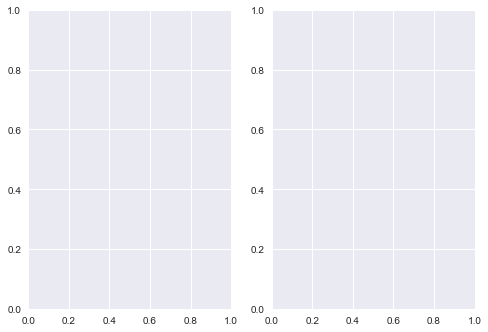

In [26]:
# Logistic regression
from sklearn.linear_model import LogisticRegression
# setup figure
fig, (ax_lda, ax_logreg) = plt.subplots(1, 2)
# LDA
plot_boundary(lda, X, y, ax_lda)
ax_lda.set_xlabel(columns[0])
ax_lda.set_ylabel(columns[1])
ax_lda.set_title("LDA(acc={:.3f})".format((lda.predict(X) == y).mean()))
# Logreg
logreg = LogisticRegression()
logreg.fit(X, y)
plot_boundary(logreg, X, y, ax_logreg)
ax_logreg.set_xlabel(columns[0])
ax_logreg.set_ylabel(columns[1])
ax_logreg.set_title("LogReg(acc={:.3f})".format((logreg.predict(X) == y).mean()))

Text(0.5, 1.0, 'KLR(acc=0.672)')

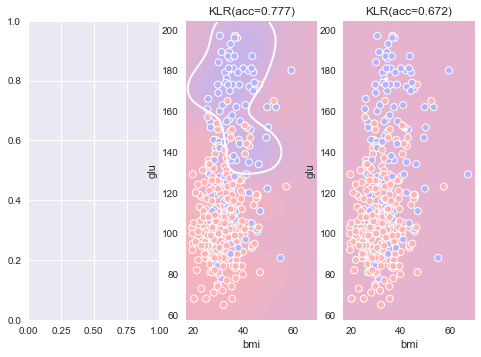

In [62]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# LogReg vs KLR
columns = ["bmi", "glu"]
labels = train["type"].values
X = train[columns].values
labeler = LabelBinarizer()
y = labeler.fit_transform(labels).flatten()
# same with test data
labels_test = test["type"].values
X_test = test[columns].values
y_test = labeler.transform(labels_test).flatten()
# setup figure
fig, (ax_logreg, ax_klr1, ax_klr2) = plt.subplots(1, 3)
# # Logreg
# plot_boundary(logreg, X_test, y_test, ax_logreg)
# ax_logreg.set_xlabel(columns[0])
# ax_logreg.set_ylabel(columns[1])
# ax_logreg.set_title("LogReg(acc={:.3f})".format((logreg.predict(X_test) == y_test).mean()))
#KLR
klr = KernelLogisticRegression(kernel = 'rbf',gamma = 0.005)
klr.fit(X,y)
plot_boundary(klr,X_test,y_test,ax_klr1)
ax_klr1.set_xlabel(columns[0])
ax_klr1.set_ylabel(columns[1])
ax_klr1.set_title("KLR(acc={:.3f})".format((klr.predict(X_test) == y_test).mean()))
# KLR
klr = KernelLogisticRegression(kernel="rbf", gamma=1.)
klr.fit(X, y)
plot_boundary(klr, X_test, y_test, ax_klr2)
ax_klr2.set_xlabel(columns[0])
ax_klr2.set_ylabel(columns[1])
ax_klr2.set_title("KLR(acc={:.3f})".format((klr.predict(X_test) == y_test).mean()))

In [63]:
from sklearn.model_selection import GridSearchCV

params = {
    'C':[0.01,0.1,1.,10.,100.],
    'gamma':[0.001,0.005,0.01,0.05,0.1,0.5,1.,]
}
cv = GridSearchCV(klr,params, cv =5, scoring = 'accuracy').fit(X,y)


In [64]:
print(cv.best_params_)

{'C': 1.0, 'gamma': 0.001}


Text(0.5, 1.0, 'KLR(acc=0.774)')

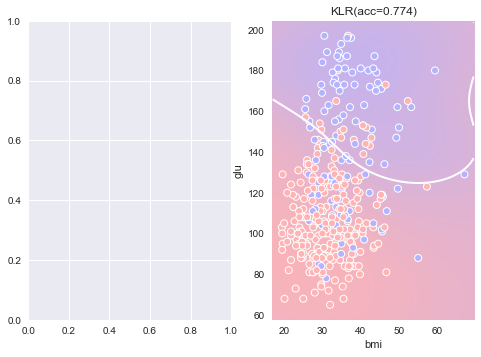

In [65]:
fig, (ax_logreg, ax_klr1) = plt.subplots(1, 2)
klr_best = cv.best_estimator_
plot_boundary(klr_best, X_test, y_test, ax_klr1)
ax_klr1.set_xlabel(columns[0])
ax_klr1.set_ylabel(columns[1])
ax_klr1.set_title("KLR(acc={:.3f})".format((klr_best.predict(X_test) == y_test).mean()))

In [51]:
pairwise_kernels(X,metric = 'poly',) 

array([[7.17330597e+10, 6.73375402e+11, 5.71814280e+10, ...,
        1.36904611e+11, 1.73538493e+11, 3.70053445e+11],
       [6.73375402e+11, 7.22095755e+12, 5.03938365e+11, ...,
        1.27040417e+12, 1.69533924e+12, 3.75292436e+12],
       [5.71814280e+10, 5.03938365e+11, 4.69021532e+10, ...,
        1.09713746e+11, 1.35802292e+11, 2.84513799e+11],
       ...,
       [1.36904611e+11, 1.27040417e+12, 1.09713746e+11, ...,
        2.61552164e+11, 3.30084069e+11, 7.01600035e+11],
       [1.73538493e+11, 1.69533924e+12, 1.35802292e+11, ...,
        3.30084069e+11, 4.24825696e+11, 9.16092729e+11],
       [3.70053445e+11, 3.75292436e+12, 2.84513799e+11, ...,
        7.01600035e+11, 9.16092729e+11, 1.99633035e+12]])

In [55]:
params = {'gamma':1,
                     'degree':3,
                     'coef0':1}
pairwise_kernels(X,metric = 'poly',filter_params = True, **params) +1

array([[5.73657332e+11, 5.38608136e+12, 4.57273339e+11, ...,
        1.09491816e+12, 1.38793463e+12, 2.95980908e+12],
       [5.38608136e+12, 5.77631774e+13, 4.03074705e+12, ...,
        1.01618258e+13, 1.35610078e+13, 3.00204970e+13],
       [4.57273339e+11, 4.03074705e+12, 3.75061181e+11, ...,
        8.77434985e+11, 1.08610132e+12, 2.27559134e+12],
       ...,
       [1.09491816e+12, 1.01618258e+13, 8.77434985e+11, ...,
        2.09192657e+12, 2.64009945e+12, 5.61185284e+12],
       [1.38793463e+12, 1.35610078e+13, 1.08610132e+12, ...,
        2.64009945e+12, 3.39792747e+12, 7.32760999e+12],
       [2.95980908e+12, 3.00204970e+13, 2.27559134e+12, ...,
        5.61185284e+12, 7.32760999e+12, 1.59687403e+13]])

In [57]:
pairwise_kernels(X,metric = 'poly',filter_params = True, **params)

array([[5.73657332e+11, 5.38608136e+12, 4.57273339e+11, ...,
        1.09491816e+12, 1.38793463e+12, 2.95980908e+12],
       [5.38608136e+12, 5.77631774e+13, 4.03074705e+12, ...,
        1.01618258e+13, 1.35610078e+13, 3.00204970e+13],
       [4.57273339e+11, 4.03074705e+12, 3.75061181e+11, ...,
        8.77434985e+11, 1.08610132e+12, 2.27559134e+12],
       ...,
       [1.09491816e+12, 1.01618258e+13, 8.77434985e+11, ...,
        2.09192657e+12, 2.64009945e+12, 5.61185284e+12],
       [1.38793463e+12, 1.35610078e+13, 1.08610132e+12, ...,
        2.64009945e+12, 3.39792747e+12, 7.32760999e+12],
       [2.95980908e+12, 3.00204970e+13, 2.27559134e+12, ...,
        5.61185284e+12, 7.32760999e+12, 1.59687403e+13]])

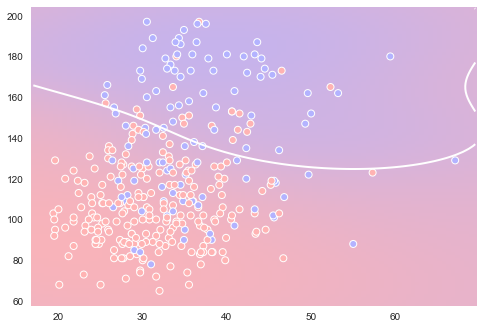

In [69]:
X,y = X_test, y_test 
dim = [0,1]
res =100
fit = klr_best
fig,ax = plt.subplots()
ax.scatter(X[:, dim[0]], X[:, dim[1]], c=y, cmap="red_blue_classes",
              linewidths=1., edgecolors="white")
xrange = ax.get_xlim()
yrange = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(*xrange, res),
                         np.linspace(*yrange, res))
xxf = xx.flatten()
yyf = yy.flatten()
xm = X.mean(0)
XX = np.vstack([xm for _ in range(xxf.shape[0])])
XX[:, dim[0]] = xxf
XX[:, dim[1]] = yyf
ZZ = fit.predict_proba(XX)
zz = ZZ[:, 1].reshape(xx.shape)
ax.pcolormesh(xx, yy, zz, cmap='red_blue_classes', shading="auto",
                   norm=colors.Normalize(0., 1.), zorder=0)
ax.contour(xx, yy, zz, [0.5], linewidths=2., colors='white')

In [76]:
xxf.shape

(10000,)

In [80]:
np.vstack([xm for _ in range(xxf.shape[0])]).shape

(10000, 2)

In [79]:
XX.shape

(10000, 2)